### Installs the Required Dependencies


In [18]:
!pip install -U pandas
!pip install -U matplotlib
!pip install -U python-dotenv

!pip install nx-arangodb
!pip install arango-datasets

!pip install google-genai
!pip install langchain-openai
!pip install langchain-mistralai

!pip install langchain
!pip install langchain-google-genai
!pip install -U langchain-community
!pip install langgraph

!pip install python-louvain



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip insta

### Imports the packages


In [1]:
# Import required modules
import json
import os
from pydantic import BaseModel, Field
from typing import Optional, List, Dict, Tuple, Literal, Union, Any
from typing_extensions import Annotated, TypedDict
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import networkx as nx
import nx_arangodb as nxadb
from pathlib import Path  
from dotenv import load_dotenv
# import cudf
# import cugraph


from arango import ArangoClient
from arango_datasets import Datasets
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.graphs import ArangoGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI
from langchain.chains import ArangoGraphQAChain
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from langchain.chains import ArangoGraphQAChain
import community as community_louvain 




# Gemini SDK Packages
from google import genai

# OpenAI SDK Packages
from openai import OpenAI

[20:35:57 -0800] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


### Loads the env variables


In [2]:

load_dotenv()


ARANGO_HOST = os.environ["ARANGO_HOST"]
ARANGO_PASSWORD = os.environ["ARANGO_PASSWORD"]
ARANGO_USERNAME = os.environ["ARANGO_USERNAME"]
GEMINI_API = os.environ["GEMINI_API_KEY"]
OPENAI_API_KEY = os.environ["OPEN_API_KEY"]
MISTRAL_API_KEY = os.environ["MISTRAL_API_KEY"]
LANGSMITH_TRACING=os.environ["LANGSMITH_TRACING"]
LANGSMITH_ENDPOINT=os.environ["LANGSMITH_ENDPOINT"]
LANGSMITH_API_KEY=os.environ["LANGSMITH_API_KEY"]
LANGSMITH_PROJECT=os.environ["LANGSMITH_PROJECT"]

### Initialize the ArangoDB Connection, LLM Instance, and initializing the constants


##### ArangoDB Connection


In [3]:
arango_client = ArangoClient(hosts=ARANGO_HOST).db(username=ARANGO_USERNAME, password=ARANGO_PASSWORD, verify=True)

#### Gemini and OpenAI SDK Instance


In [4]:
gemini_client = genai.Client(
    api_key=GEMINI_API
)

openai_client = OpenAI(
    api_key=OPENAI_API_KEY
)

#### Model Names' Constants


In [5]:
# Gemini models
GEMINI_FLASH_MODEL = "gemini-2.0-flash"
GEMINI_FLASH_LITE_MODEL = "gemini-2.0-flash-lite"
GEMINI_PRO_MODEL = "gemini-1.5-pro"

# OpenAI Model
GPT_4O = "gpt-4o-2024-08-06"


# MistralAI Model
MISTRAL_LARGE="mistral-large-latest"


### Conditionally loads the SYNTHEA_P100 dataset in ArangoDB and creates an ArangoGraph instance using ArangoDB instance


#### Loads the dataset in ArangoDB


In [6]:
datasets = Datasets(arango_client)

DATASET_NAME = "SYNTHEA_P100"

# Conditionally Loads the Synthea P100 dataset in Arango
if not arango_client.has_graph(DATASET_NAME):
  datasets.load(dataset_name=DATASET_NAME)
else:
  print(f"{DATASET_NAME} is already in ArangoDB.")

/Users/gurneeshbudhiraja/Developer/arango-hackathon/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

SYNTHEA_P100 is already in ArangoDB.


#### Creates an ArangoGraph instance using the Arango DB instance


In [7]:
# Connects with the Graph in ArangoDB
graph = None
if arango_client.has_graph(DATASET_NAME):
  graph = nxadb.Graph(name="SYNTHEA_P100",db=arango_client)
else:
  print("Graph does not exist in Arango DB")

print(graph)

[20:35:59 -0800] [INFO]: Graph 'SYNTHEA_P100' exists.
[20:35:59 -0800] [INFO]: Default node type set to 'allergies'


Graph named 'SYNTHEA_P100' with 145514 nodes and 311701 edges


#### Graph Schema


In [8]:
arango_graph = ArangoGraph(db=arango_client)

#### Graph Plot


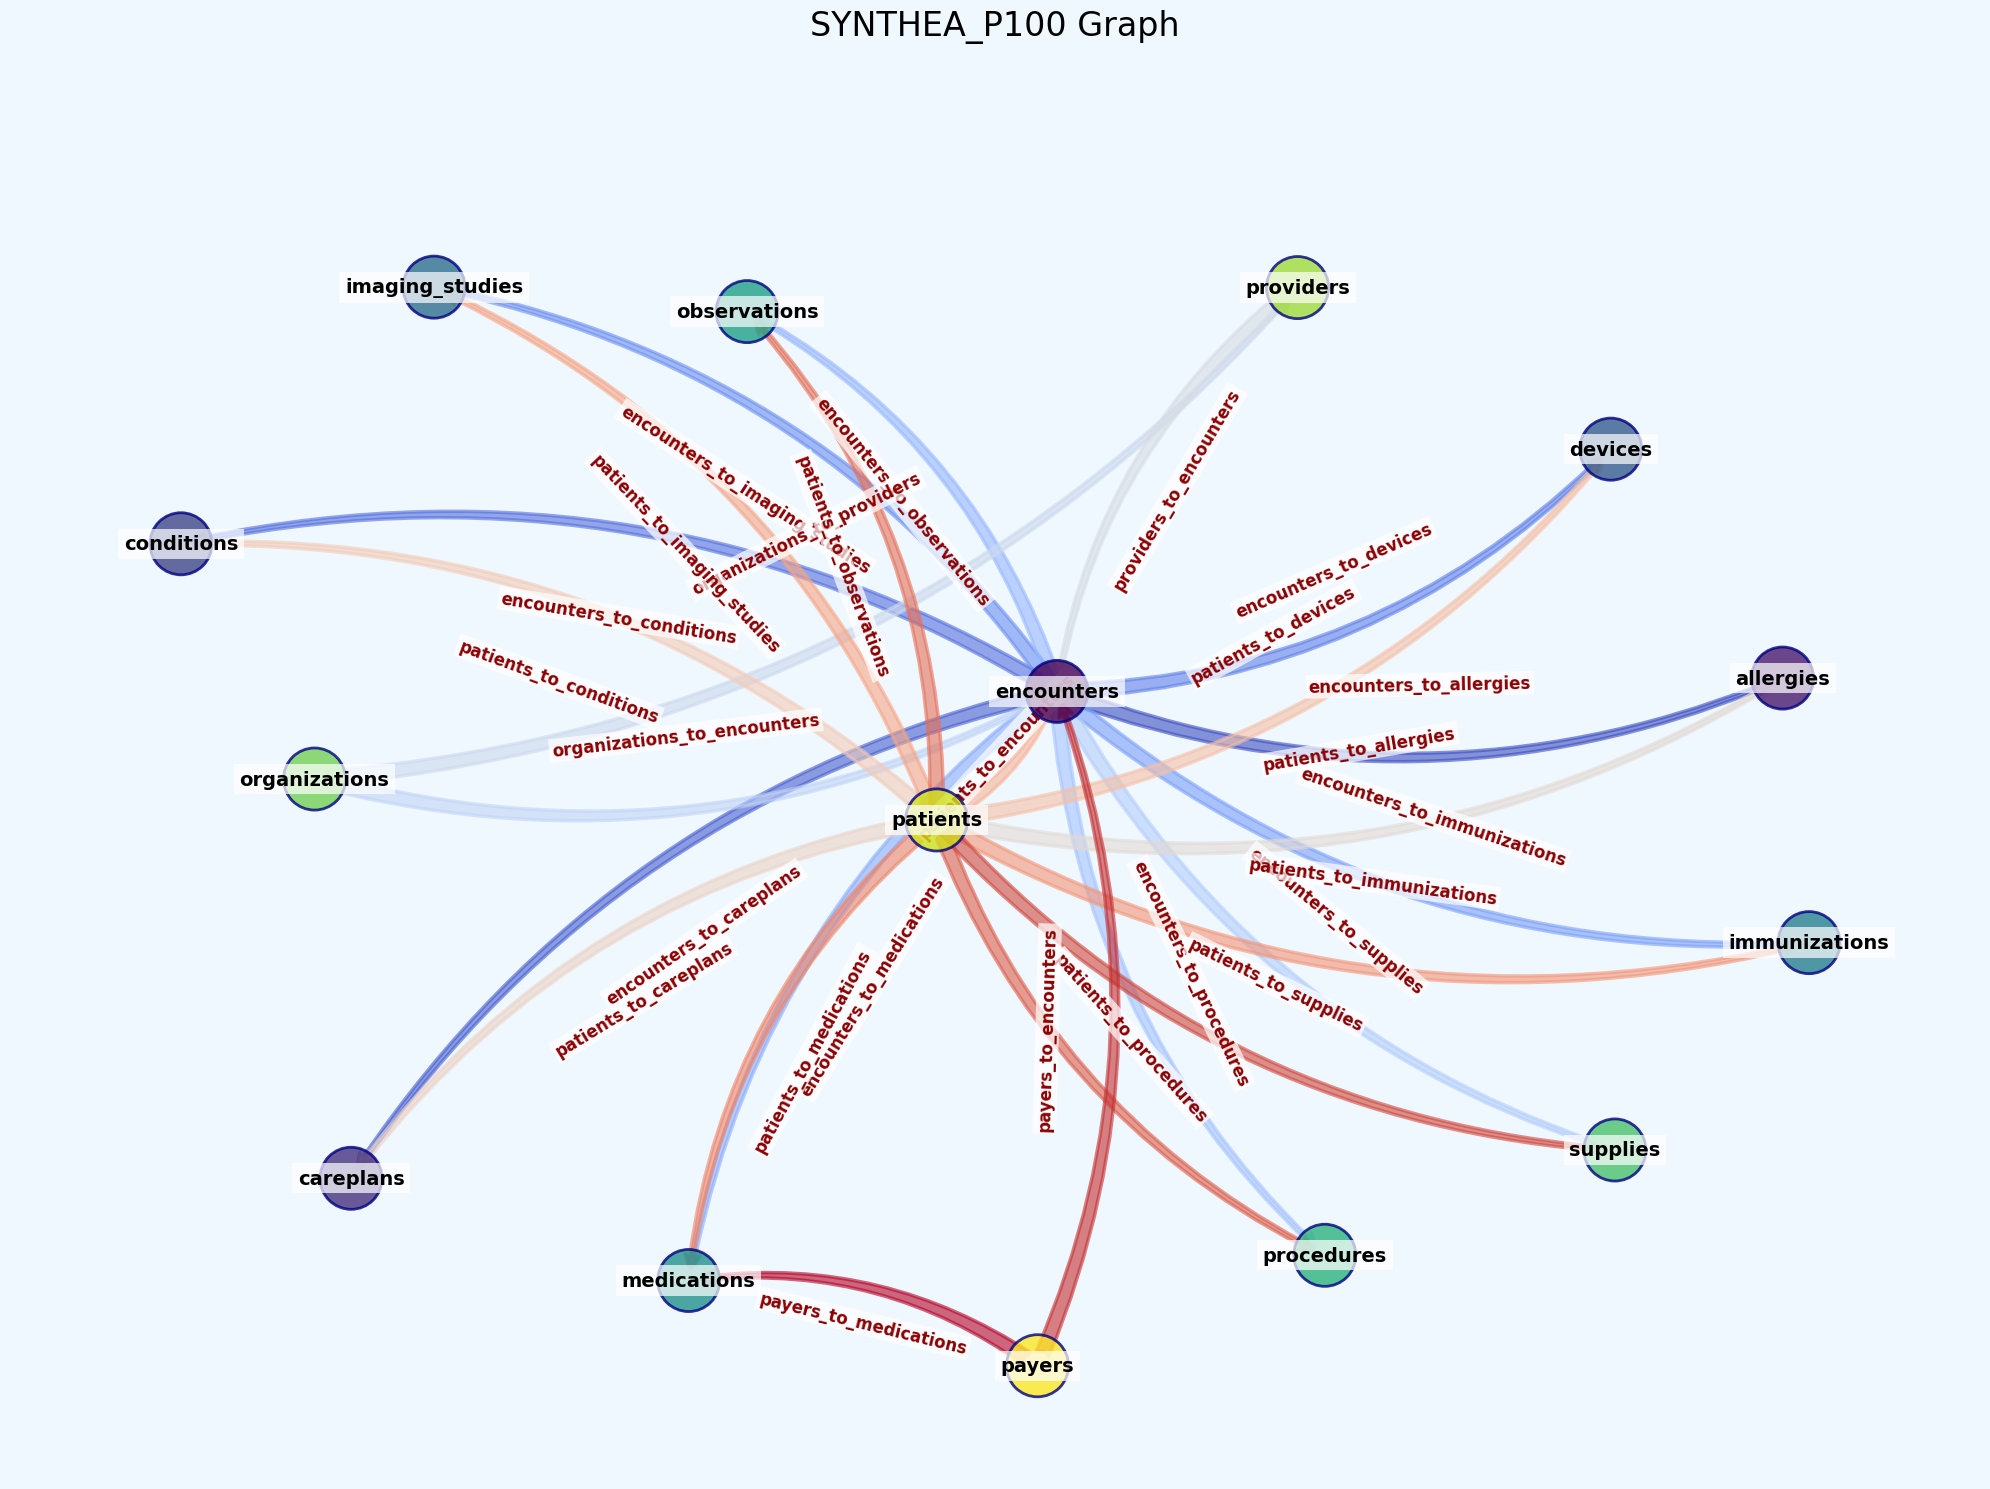

In [9]:
# Extract graph schema and edge definitions from schema data
graph_schema = arango_graph.schema["Graph Schema"][0]
edge_definitions = graph_schema["edge_definitions"]


# Create directed graph and add edges based on vertex collections
G_schema = nx.DiGraph()
for ed in edge_definitions:
    edge_collection = ed["edge_collection"]
    from_list = ed["from_vertex_collections"]
    to_list = ed["to_vertex_collections"]
    for f in from_list:
        for t in to_list:
            G_schema.add_edge(f, t, label=edge_collection)


# Set the layout for the graph visualization
pos = nx.spring_layout(G_schema, k=2, seed=42)


# Create figure with light blue background
plt.figure(figsize=(20, 15), facecolor='#f0f8ff')


# Draw nodes with color gradient
node_colors = plt.cm.viridis(np.linspace(0, 1, len(G_schema.nodes())))
nx.draw_networkx_nodes(
    G_schema, pos,
    node_size=2000,
    node_color=node_colors,
    edgecolors='navy',
    linewidths=2.0,
    alpha=0.8
)


# Draw edges with color gradient and curved arrows
edge_colors = plt.cm.coolwarm(np.linspace(0, 1, len(G_schema.edges())))
nx.draw_networkx_edges(
    G_schema, pos,
    arrowstyle='fancy',
    arrowsize=25,
    edge_color=edge_colors,
    width=2.5,
    connectionstyle='arc3,rad=0.2',
    alpha=0.6
)


# Add node labels with white background
nx.draw_networkx_labels(
    G_schema, pos,
    font_size=14,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=4)
)


# Add edge labels with white background
edge_labels = nx.get_edge_attributes(G_schema, 'label')
nx.draw_networkx_edge_labels(
    G_schema, pos,
    edge_labels=edge_labels,
    font_color='darkred',
    font_size=12,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2)
)

plt.title("SYNTHEA_P100 Graph", fontsize=24, pad=100)
plt.axis("off")
plt.tight_layout()


plt.grid(True, linestyle='--', alpha=0.5)

plt.show()



### AQL Agent


In [42]:
def aql_agent(user_query:str):
  # LLM
  aql_llm = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_LITE_MODEL,
    api_key=GEMINI_API,
    temperature=0.2,
  )

  print("=============== Running the ArangoGraphQAChain ===============")
  chain = ArangoGraphQAChain.from_llm(
    llm=aql_llm, 
    graph=arango_graph, 
    verbose=True,
    allow_dangerous_requests=True,
    )

  aql_chain_response = chain.invoke([HumanMessage(content=user_query)])
  return aql_chain_response


### Louvain Agent

- The agent is used to handle queries that are best to be solved using the Louvain Agent


#### Tools for the Louvain Agent


#### Defining the tools


#### Tool Schemas


In [11]:
class ExtractDataSchema(BaseModel):
    entity_type: str
    filter: str 
    analysis: str 

#### Louvian Agent Tools


In [12]:
# Global variable for the visualisation tool
visaulise_G = None
visaulise_partition = None

@tool
def extract_data(user_query:str):
  """
    The tool takes in the initial user_query and returns a dictionary with the following keys:
    - "entity_type": the type of entity the query is about (e.g., "patients", "providers", or "medications"). 
    - "filter": any specific filter criteria mentioned in the query (for example, "shared_conditions" if the query mentions shared conditions) and otherwise "none"
    - "analysis": the type of analysis to perform; since this is the community detection agent, this should always be "community_detection".
  """

  print(f"\n\n=============== Using the extract_data tool ===============\nExtracting entity_type, filter, and shared_conditions from the following user_query:\n{user_query}\n")
  
  # LLM
  llm = ChatGoogleGenerativeAI(
    temperature=0.2,
    api_key=GEMINI_API,
    model=GEMINI_FLASH_MODEL,
    verbose=True
  )

  output_parser = JsonOutputParser(pydantic_object=ExtractDataSchema)
  
  llm_prompt = PromptTemplate(
    template="""
      You are an expert in data analytics and network analysis. When given a user query related to community detection in a graph (for example, the Synthea_P100 dataset), you should extract and return a structured JSON output containing the following keys:
        - "entity_type": the type of entity the query is about (e.g., "patients", "providers", or "medications").
        - "filter": any specific filter criteria mentioned in the query (for example, "shared_conditions" if the query mentions shared conditions) and otherwise "none"
        - "analysis": the type of analysis to perform; since this is the community detection agent, this should always be "community_detection"..Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.
    """,
    input_variables=["user_query"],
    partial_variables={"format_instructions": output_parser.get_format_instructions()},
  )

  chain = llm_prompt | llm | output_parser
  chain_response = chain.invoke({"user_query": user_query})
  print("\n\n================== extract_data tool Response ==================")
  print(chain_response)
  print("\n\n")
  return chain_response

@tool
def louvain_aql_generator(user_query:str, entity_type:str, filter:str, analysis:str):
  """
    The tool is used to generate an AQL query and returns the results for the other tools.

    Args:
      user_query: str = The user query asked by the user.
      entity_type: str = Entity type generated using the other tool
      filter: str = filter from the initial user query.
      analysis: str = analysis from the user query. 
    
    Returns:
      Response after the execution of the generated AQL query.
  """
  print(f"\n\n=============== Using the louvain_aql_generator tool ===============\n")

  # GEMINI Model
  louvain_aql_llm = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.2,
  )
  
  # OpenAI Model
  # louvain_aql_llm = ChatOpenAI(
  #   model=GPT_4O,
  #   api_key=OPENAI_API_KEY,
  #   temperature=0.2,
  # )

  # Mistral Model
  # louvain_aql_llm = ChatMistralAI(
  #   model=MISTRAL_LARGE,
  #   api_key=MISTRAL_API_KEY,
  #   temperature=0.5,
  # )

  aql_chain = ArangoGraphQAChain.from_llm(
    llm=louvain_aql_llm, 
    graph=graph, 
    verbose=True,
    allow_dangerous_requests=True,
  )
  aql_chain.return_aql_result = True

  aql_chain_response = aql_chain.invoke(f"""
    This is the user query asked by the user: {user_query} and this is the data that is extracted by the AI model from the query: 
      entity_type: {entity_type}
      filter: {filter}
      analysis: {analysis}
    Your job is to
  """)
  

  return aql_chain_response 

@tool
def build_graph(edge_list: List[Dict[str, Any]]) -> tuple:
    """
    Builds a NetworkX graph from the edge list and applies the Louvain algorithm
    to detect communities.
    
    Args:
        edge_list (List[Dict[str, Any]]): A list of dictionaries, where each dictionary contains:
            - "source": The ID of the source node (e.g., string).
            - "target": The ID of the target node (e.g., string).
            This list represents the edges between nodes in the graph.
    
    Returns:
        G (networkx.Graph): The constructed graph with nodes and edges.
        partition (dict): A dictionary mapping each node ID to its detected community.
            - The key is the node ID (e.g., "providers/0019b658-e00c-37c0-9344-339827a460c9").
            - The value is the community ID (e.g., an integer like 0, 1, 2, etc.), representing the community to which the node belongs.
    """
    global visaulise_G, visaulise_partition
    print(f"\n\n=============== Using the build_graph tool ===============\n")
    print(edge_list)
    # Construct the graph
    G = nx.Graph()
    for edge in edge_list:
        G.add_edge(edge["source"], edge["target"])
    
    # Apply Louvain algorithm to detect communities
    partition = community_louvain.best_partition(G)
    
    # Assigns the visualise_G and visualise_partition to G and partition
    visaulise_G = G
    visaulise_partition = partition
    
    return G, partition


def visualize_communities() -> None:
    """
    Visualizes the graph G with nodes colored by community based on the partition.

    Args: 
      None: This function uses the global variables visaulise_G and visaulise_partition to plot the graph
    
    Returns:
        None: This function only plots the graph and doesn't return any value.
    """
    print(f"\n\n=============== Using the visualize_communities tool ===============\n")
    
    # Generate the layout for the graph
    pos = nx.spring_layout(visaulise_G, k=0.2, iterations=50)

    plt.figure(figsize=(20, 20))

    # Get unique community labels and assign a color for each community
    communities = set(visaulise_partition.values())
    colors = plt.cm.rainbow([i/len(communities) for i in range(len(communities))])
    community_color_map = {com: color for com, color in zip(communities, colors)}

    # Draw nodes with color based on community
    for node, community in visaulise_partition.items():
        nx.draw_networkx_nodes(
            visaulise_G, 
            pos,
            nodelist=[node],
            node_color=[community_color_map[community]],
            node_size=500,
            alpha=0.8
        )

    # Draw edges in gray
    nx.draw_networkx_edges(visaulise_G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(visaulise_G, pos, font_size=8)

    plt.title("Community Detection using Louvain")
    plt.axis('off')
    plt.show()


#### Starter function for the Community Detection Louvain Agent


In [13]:

def louvain_agent(user_query:str):
  # Agent tools
  louvain_agent_tools = [extract_data,louvain_aql_generator, build_graph]
  
  # =========== Gemini Model ===========
  # model = init_chat_model(
  #   model=GEMINI_FLASH_MODEL, 
  #   temperature=0.2, 
  #   model_provider="google_genai",
  #   api_key=GEMINI_API
  # )
  
  # =========== OPEN AI Model ===========
  model = init_chat_model(
    model=GPT_4O, 
    temperature=0.4, 
    model_provider="openAI",
    api_key=OPENAI_API_KEY
  )

  # =========== MistralAI Model ===========

  # model = init_chat_model(
  #   model=MISTRAL_LARGE, 
  #   temperature=0.4, 
  #   model_provider="mistralai",
  #   api_key=MISTRAL_API_KEY
  # )

  agent_executor = create_react_agent(
    model=model,
    tools=louvain_agent_tools,
    prompt="""
      You are the community_detection_louvain_agent. Your primary responsibility is to use only the provided tools to extract and process data in order to answer the user's query regarding community detection. Follow these guidelines:

      User Query Processing:
        You will receive a user query that is best solved by your capabilities.
        Parse and extract the required parameters (e.g., entity type, filter, analysis) using the provided extract_data tool.
      
      Tool Utilization:
        Use the AQL generator tool to create a query that retrieves the necessary graph data.
        Then, use the build_graph tool to construct a NetworkX graph and apply the Louvain community detection algorithm.

        If the user requests a visualization, after building the graph, run the visualize_communities tool to generate an interactive or static visual output.
        If the user does not request a visualization, your final tool call should be the build_graph tool, and you will present the answer in natural language.
      
      Final Answer:
        Use the data extracted from all the tools to generate a final, friendly, and positive natural language response.
      
      Follow any additional instructions mentioned in the query.
      
      Remember:
        Provide a concise summary if no visualization is requested.
        If visualization is requested, ensure the final response includes both the graph (via visualization tool) and a brief summary of the findings.

    """
  )
  response = agent_executor.invoke({"messages":[HumanMessage(content=f"This is the user query: {user_query}")]})
  return response
  

### NetworkX Starter Agent


#### Schema


In [91]:
class DC_QueryParserSchema(BaseModel):
  entity_type: str = Field(default="", description="Entity type to query (e.g., patients)")
  top_n: int = Field(default=5, description="Number of top results to return")
  relationship: str = Field(default="direct relationships", description="Type of relationships to consider")

class DC_QueryGenerator(BaseModel):
  aql_query: str = Field(default="", description="AQL query to execute")

#### Tools


In [97]:

def dc_query_parser(user_query:str):
  """
  The function takes in the initial user query and returns a dictionary containing the entity_type, top_n, and graph relationship

  Args: 
    user_query: str = Query asked by the user.
  
  Returns:
    {
        "entity_type": str,
        "top_n": int,
        "graph": str
    }
  """
  query_output_parser = JsonOutputParser(pydantic_object=DC_QueryParserSchema)

  prompt = PromptTemplate(
      template="""You are a helpful assistant that parses the user query to extract the entity_type, top_n, and graph relationship. Follow these instructions for giving the output: {format_instructions}. This is the user query asked by the user: {user_query}""",
      input_variables=["user_query"],
      partial_variables={"format_instructions": query_output_parser.get_format_instructions()}
  )

  llm = ChatGoogleGenerativeAI(
    model=GEMINI_PRO_MODEL,
    api_key=GEMINI_API,
    temperature=0
  )

  chain = prompt | llm | query_output_parser
  response = chain.invoke({"user_query": user_query})
  return response


def dc_query_generator(user_query:str, entity_type:str, top_n:int, relationship:str):
  """
  The tool is used to generate and return the result of AQL queries.

  Args:
    user_query:str = The initial user query entered by the user
    entity_type: str = The type of entity to be queried.
    top_n: int = The number of top entities to be queried.
    relationship: str = The graph relationship to be queried.

  Returns:
    The result of the AQL query.
  """

  # parser
  dc_query_parser = JsonOutputParser(pydantic_object=DC_QueryParserSchema)

  prompt = PromptTemplate(
    template="""
      You are given an ArangoDB graph with a node collection and several edge collections. The node collection is named "{entity_type}" and you should consider edges representing "{relationship}". 

      Generate a JSON object with two keys:
      - "node_query": an AQL query that retrieves all documents from the node collection "{entity_type}". For example:
        FOR doc IN {entity_type}
            RETURN doc
      - "edge_queries": a JSON object mapping each of the following edge collections to an AQL query that retrieves all its documents:
          - patients_to_allergies
          - patients_to_careplans
          - patients_to_conditions
          - patients_to_devices
          - patients_to_encounters
          - patients_to_imaging_studies
          - patients_to_immunizations
          - patients_to_medications
          - patients_to_observations
          - patients_to_procedures
          - patients_to_supplies

      For each edge collection, the query should be in the format:
        FOR edge IN <edge_collection>
            RETURN edge

      Return the final result as a JSON object with the keys "node_query" and "edge_queries". Follow these instructions while generating the output: {format_instructions}
  """,
    input_variables=["entity_type","relationship"],
    partial_variables={"format_instructions": dc_query_parser.get_format_instructions()}
  )
  
  
  aql_llm = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.2
  )
  chain = prompt | aql_llm | dc_query_parser
  return chain.invoke({
    "entity_type": entity_type,
    "relationship": relationship
  })



In [114]:
user_query = "Identify the top 10 most connected conditions in the Synthea_P100 dataset based on their direct relationships."
parser_response = dc_query_parser(user_query=user_query)

In [115]:
parser_response

{'entity_type': 'conditions',
 'top_n': 10,
 'relationship': 'direct relationships'}

In [116]:
et = parser_response["entity_type"]
rlship = parser_response["relationship"]
tp_n = parser_response["top_n"]

query_response = dc_query_generator(user_query=user_query,entity_type=et, relationship=rlship, top_n=tp_n)


In [117]:
query_response

{'node_query': 'FOR doc IN conditions\n  RETURN doc',
 'edge_queries': {'patients_to_allergies': 'FOR edge IN patients_to_allergies\n  RETURN edge',
  'patients_to_careplans': 'FOR edge IN patients_to_careplans\n  RETURN edge',
  'patients_to_conditions': 'FOR edge IN patients_to_conditions\n  RETURN edge',
  'patients_to_devices': 'FOR edge IN patients_to_devices\n  RETURN edge',
  'patients_to_encounters': 'FOR edge IN patients_to_encounters\n  RETURN edge',
  'patients_to_imaging_studies': 'FOR edge IN patients_to_imaging_studies\n  RETURN edge',
  'patients_to_immunizations': 'FOR edge IN patients_to_immunizations\n  RETURN edge',
  'patients_to_medications': 'FOR edge IN patients_to_medications\n  RETURN edge',
  'patients_to_observations': 'FOR edge IN patients_to_observations\n  RETURN edge',
  'patients_to_procedures': 'FOR edge IN patients_to_procedures\n  RETURN edge',
  'patients_to_supplies': 'FOR edge IN patients_to_supplies\n  RETURN edge'}}

In [118]:
node_query = query_response["node_query"]
nodes_cursor = arango_client.aql.execute(node_query)
nodes = list(nodes_cursor)  # Convert cursor to list for processing

# Initialize an empty graph
G = nx.Graph()

# Add nodes to the graph
# Assuming each node document has a unique '_id' field.
for node in nodes:
    G.add_node(node['_id'])


In [119]:
edge_queries = query_response["edge_queries"]

for collection, query in edge_queries.items():
    edges_cursor = arango_client.aql.execute(query)
    for edge in edges_cursor:
        # Typically, the edge document contains _from and _to fields in the format "collection_name/document_key"
        # We can extract just the document keys if needed.
        source = edge["_from"].split("/")[-1]
        target = edge["_to"].split("/")[-1]
        
        # Optionally, ensure that both nodes exist before adding an edge:
        if source not in G.nodes():
            G.add_node(source)
        if target not in G.nodes():
            G.add_node(target)
        
        G.add_edge(source, target)


In [121]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())




Number of nodes: 117943
Number of edges: 144240


In [127]:
# Compute degree centrality for all nodes in the graph
degree_centrality = nx.degree_centrality(G)

# Step 2: Sort nodes by centrality score in descending order and extract the top 10
top_n = 10
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_conditions = sorted_centrality[:top_n]

# Step 3: Print the results
print("Top 10 most connected conditions based on degree centrality:")
for condition, centrality in top_10_conditions:
    print(f"Condition ID: {condition}, Degree Centrality: {centrality:.4f}")


Top 10 most connected conditions based on degree centrality:
Condition ID: 01fd0320-1260-3613-95fb-7703f53e6a08, Degree Centrality: 0.0911
Condition ID: cf473b4b-6f5f-1fb7-6a9f-466bcdcda219, Degree Centrality: 0.0821
Condition ID: 8a9997b5-b610-cdd9-7d2c-84a6c44e2985, Degree Centrality: 0.0743
Condition ID: a083a9c0-dc60-926d-e3c6-0dbb3808a6c6, Degree Centrality: 0.0730
Condition ID: 25363102-9729-1ae1-df47-0e1111c32679, Degree Centrality: 0.0722
Condition ID: 32234ae3-f0e7-2ca7-32aa-c9cb32e643f2, Degree Centrality: 0.0548
Condition ID: b85c0c7d-02b1-0518-75de-b4c3fb33c5b8, Degree Centrality: 0.0394
Condition ID: d6f0af7b-b1f7-3fe2-ef7b-33e0170d487a, Degree Centrality: 0.0334
Condition ID: 6366d25d-0287-484d-e66f-c5a3a9d58ea7, Degree Centrality: 0.0301
Condition ID: c87416d5-a1b2-4dc8-73fd-e9f3ae4d7c8d, Degree Centrality: 0.0199


In [129]:
total_nodes = G.number_of_nodes()
for condition, centrality in top_10_conditions:
    degree = G.degree(condition)
    expected_centrality = degree / (total_nodes - 1)
    print(f"Condition: {condition}, Degree: {degree}, Expected Centrality: {expected_centrality:.4f}, Computed Centrality: {centrality:.4f}")


Condition: 01fd0320-1260-3613-95fb-7703f53e6a08, Degree: 10748, Expected Centrality: 0.0911, Computed Centrality: 0.0911
Condition: cf473b4b-6f5f-1fb7-6a9f-466bcdcda219, Degree: 9679, Expected Centrality: 0.0821, Computed Centrality: 0.0821
Condition: 8a9997b5-b610-cdd9-7d2c-84a6c44e2985, Degree: 8768, Expected Centrality: 0.0743, Computed Centrality: 0.0743
Condition: a083a9c0-dc60-926d-e3c6-0dbb3808a6c6, Degree: 8611, Expected Centrality: 0.0730, Computed Centrality: 0.0730
Condition: 25363102-9729-1ae1-df47-0e1111c32679, Degree: 8518, Expected Centrality: 0.0722, Computed Centrality: 0.0722
Condition: 32234ae3-f0e7-2ca7-32aa-c9cb32e643f2, Degree: 6465, Expected Centrality: 0.0548, Computed Centrality: 0.0548
Condition: b85c0c7d-02b1-0518-75de-b4c3fb33c5b8, Degree: 4652, Expected Centrality: 0.0394, Computed Centrality: 0.0394
Condition: d6f0af7b-b1f7-3fe2-ef7b-33e0170d487a, Degree: 3937, Expected Centrality: 0.0334, Computed Centrality: 0.0334
Condition: 6366d25d-0287-484d-e66f-c5a3

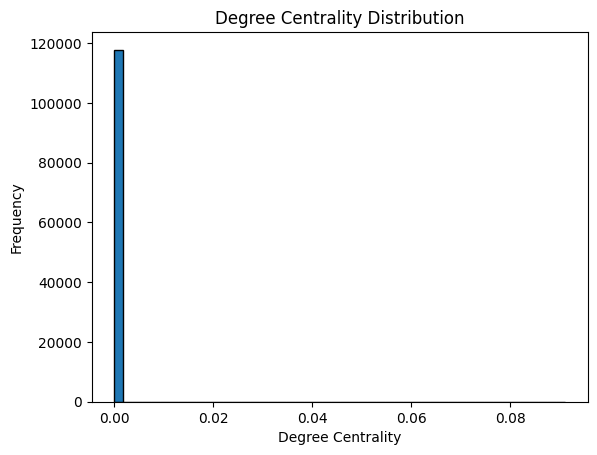

In [126]:
import matplotlib.pyplot as plt

all_centrality_values = list(degree_centrality.values())
plt.hist(all_centrality_values, bins=50, edgecolor='black')
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.title("Degree Centrality Distribution")
plt.show()


In [130]:
import matplotlib.pyplot as plt

# Compute positions for all nodes (spring layout is commonly used)
pos = nx.spring_layout(G, k=0.1)  # Adjust k for spacing if needed

# Draw the entire graph (for a large graph, this might be too cluttered)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=10, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph Visualization")
plt.axis("off")
plt.show()


KeyboardInterrupt: 

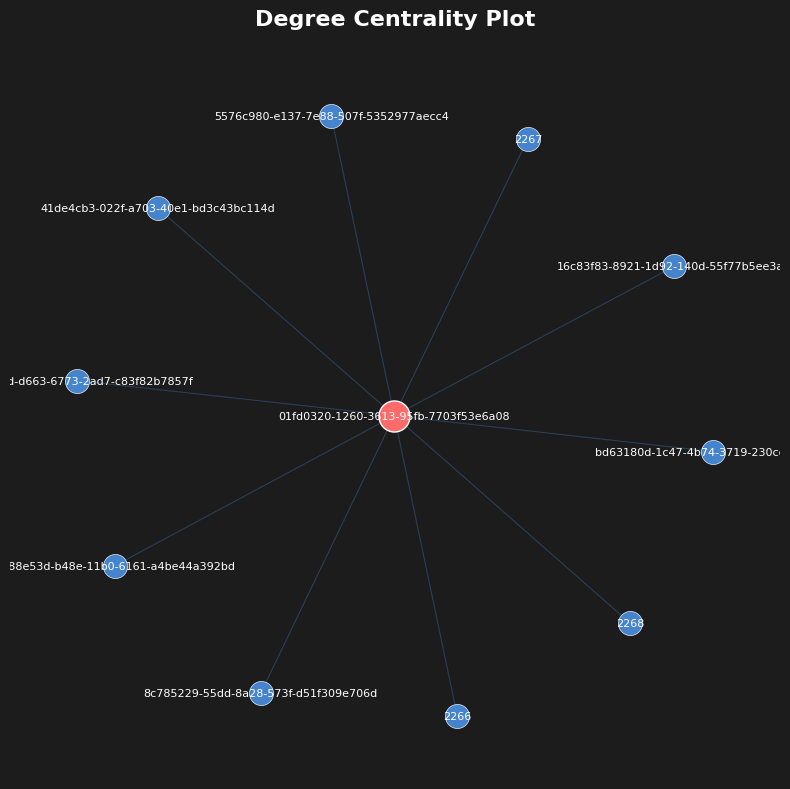

In [ ]:
# Get the highest-degree node
top_node, _ = max(degree_centrality.items(), key=lambda x: x[1])
# Get a limited number of neighbors (for example, 5 neighbors)
neighbors = list(G.neighbors(top_node))[:10]
subgraph_nodes = [top_node] + neighbors

subG = G.subgraph(subgraph_nodes)

# Create figure with a dark background
plt.style.use('dark_background')
plt.figure(figsize=(8, 8), facecolor='#1C1C1C')
plt.gca().set_facecolor('#1C1C1C')

# Use a more visually appealing layout
sub_pos = nx.spring_layout(subG, k=0.8)

# Draw edges with a glowing effect
nx.draw_networkx_edges(subG, sub_pos, alpha=0.3, edge_color='#4A90E2', width=0.8)

# Draw regular nodes with a modern blue color and slight transparency
nx.draw_networkx_nodes(subG, sub_pos, 
                      node_size=300,
                      node_color='#4A90E2',
                      alpha=0.9,
                      edgecolors='white',
                      linewidths=0.5)

# Highlight the top node with a contrasting color and larger size
nx.draw_networkx_nodes(subG, sub_pos,
                      nodelist=[top_node],
                      node_size=500,
                      node_color='#FF6B6B',
                      alpha=1,
                      edgecolors='white',
                      linewidths=1)

# Add labels with improved visibility
nx.draw_networkx_labels(subG, sub_pos,
                      font_size=8,
                      font_color='white',
                      font_weight='light')

plt.title("Degree Centrality Plot", 
          fontsize=16,
          color='white',
          pad=20,
          fontweight='bold')
plt.axis("off")

# Add a tight layout and display
plt.tight_layout()
plt.show()


In [101]:
cursor = arango_client.aql.execute("""
WITH patients, patients_to_allergies, patients_to_careplans, patients_to_conditions, patients_to_devices, patients_to_encounters, patients_to_imaging_studies, patients_to_immunizations, patients_to_medications, patients_to_observations, patients_to_procedures, patients_to_supplies
LET node_query = (
    FOR doc IN patients
        RETURN doc
)
LET edge_queries = {
    "patients_to_allergies": (
        FOR edge IN patients_to_allergies
            RETURN edge
    ),
    "patients_to_careplans": (
        FOR edge IN patients_to_careplans
            RETURN edge
    ),
    "patients_to_conditions": (
        FOR edge IN patients_to_conditions
            RETURN edge
    ),
    "patients_to_devices": (
        FOR edge IN patients_to_devices
            RETURN edge
    ),
    "patients_to_encounters": (
        FOR edge IN patients_to_encounters
            RETURN edge
    ),
    "patients_to_imaging_studies": (
        FOR edge IN patients_to_imaging_studies
            RETURN edge
    ),
    "patients_to_immunizations": (
        FOR edge IN patients_to_immunizations
            RETURN edge
    ),
    "patients_to_medications": (
        FOR edge IN patients_to_medications
            RETURN edge
    ),
    "patients_to_observations": (
        FOR edge IN patients_to_observations
            RETURN edge
    ),
    "patients_to_procedures": (
        FOR edge IN patients_to_procedures
            RETURN edge
    ),
    "patients_to_supplies": (
        FOR edge IN patients_to_supplies
            RETURN edge
    )
}
RETURN {
    "node_query": node_query,
    "edge_queries": edge_queries
}
""")

list(cursor)

[{'node_query': [{'_key': '7c2e78bd-52cf-1fce-acc3-0ddd93104abe',
    '_id': 'patients/7c2e78bd-52cf-1fce-acc3-0ddd93104abe',
    '_rev': '_jSkqkQ2---',
    'BIRTHDATE': '2021-12-01',
    'SSN': '999-34-1010',
    'FIRST': 'Shila857',
    'LAST': 'Kshlerin58',
    'RACE': 'white',
    'ETHNICITY': 'hispanic',
    'GENDER': 'F',
    'BIRTHPLACE': 'Fall River  Massachusetts  US',
    'ADDRESS': '571 Zemlak Annex Unit 25',
    'CITY': 'Scituate',
    'STATE': 'Massachusetts',
    'COUNTY': 'Plymouth County',
    'FIPS': 25023,
    'ZIP': 2066,
    'LAT': 42.21637129800291,
    'LON': -70.714864560875,
    'HEALTHCARE_EXPENSES': 3672.68,
    'HEALTHCARE_COVERAGE': 3026.74,
    'INCOME': 41426},
   {'_key': 'ee070281-5df4-601c-8660-d40e7ea76def',
    '_id': 'patients/ee070281-5df4-601c-8660-d40e7ea76def',
    '_rev': '_jSkqkQ2--_',
    'BIRTHDATE': '2020-12-27',
    'SSN': '999-21-5187',
    'FIRST': 'Dallas143',
    'LAST': 'Mueller846',
    'RACE': 'white',
    'ETHNICITY': 'nonhispanic',

In [26]:
def degree_centrality_agent(user_query:str):
  print("Degree centrality agent:", user_query)
  

### Starter function to decide which agent to be selected for the given user query


In [27]:
def main(user_query:str):

  # MainSchema Class
  class MainSchema(BaseModel):
    # Type of the agent
    agent_type: str = Field(description="""
                            The type of agent to be used to answer the user query. 
                            If the user query is best to be solved using aql then return `aql`. 
                            You will return `networkX` if the given user query will be solved using the networkX algorithms.
                            If the user query requires a combination of both aql and networkX algorithms then reply with `hybrid`.
      If the user query can not be solved efficiently using aql, any networkX agents, or hybrid that will be considered as the irrelevant query.""", default="")

    # The reason for selecting a specific agent type
    agent_type_reason: str = Field(description="The reason for the agent type.", default="")

    # When the message is not relevant
    not_relevant_message:str =  Field(description="The message to be displayed when the user query is not relevant to the dataset stored in ArangoDB.", default="")

    # if the visualisation is asked by the user
    is_visualisation_asked:bool = Field(description="Whether the user wants to visualise the answer or not.", default=False)

    # modified query
    modified_query:str = Field(description="If the user has asked the visualisation of some sort of answer then remove the visualisation part from the user query and only return the initial user query without the visualisation.", default=user_query)


  # LLM Parser
  main_parser = JsonOutputParser(pydantic_object=MainSchema)  
  
  # LLM Prompt
  main_prompt = PromptTemplate(
    template="You are working with the SYNTHEA_P100 dataset stored in ArangoDB and based on the user query your main job is to tell what would be the right agent to go for the following user query. Should I find answer to the user's problem through aql, networkX, or hybrid. Please make sure that if the user query is not related to the SYNTHEA_P100 dataset stored in ArangoDB then you can deny the request and give a short message to the user. Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.",
    input_variables=["user_query"],
    partial_variables={"format_instructions": main_parser.get_format_instructions()},
  )


  # LLM
  main_model = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.1,
    verbose=True
  )

  try:
    # LangChain LCEL Chain
    main_chain = main_prompt | main_model | main_parser 
    main_chain_response = main_chain.invoke({"user_query":user_query})
    
    return main_chain_response
  except Exception as e:
    print(e)
    return "Something went wrong. Please try again later."


def get_specialised_networkX_agent(user_query:str) -> str:
  """
    This is used to find the best networkX algorithm to solve the given user query
  """
  # Schema
  class SpecialisedNetworkXSchema(BaseModel):
    # The agent to be used to solve the user query
    specialised_agent:str = Field(description="""
        If the user query best needs to be solved using the degree centrality networkX algorithm then reply with 'degree_centrality' otherwise reply with 'other'
    """, default="")

    specialised_agent_reason:str = Field(description="The reason for the specialised agent. Also include what is the algorithm should be used to handle the user query.", default="")

    algorithm:str = Field(description="The algorithm to be used to solve the user query.", default="")

  # parser
  parser = JsonOutputParser(pydantic_object=SpecialisedNetworkXSchema)

  model = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_LITE_MODEL,
    api_key=GEMINI_API,
    temperature=0.1,
  )

  prompt = PromptTemplate(
    template="You are working with the SYNTHEA_P100 dataset stored in ArangoDB and based on the user query your main job is to tell what would be the right agent to go for the following user query. It has already been decided that the given user query would be solved using networkX but your main job is to find the specialised agent within the networkX to handle the given user query. Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.",
    input_variables=["user_query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

  chain = prompt | model | parser
  chain_response = chain.invoke({"user_query":user_query})
  return chain_response




In [43]:
try:
  user_query = ""

  while not user_query: 
    user_query = input("Enter the user query: ").strip()

  print("================= User query:", user_query,"=================\n")

  response = main(user_query=user_query)
  print(response)
  agent_type = response["agent_type"]

  # Matches the agent type 
  match agent_type:
    
    case "aql":
      print(f'============== Agent selected: AQL Agent because:\n{response["agent_type_reason"]}==============\n')      
      aql_agent_response = aql_agent(user_query=user_query)
      print("\n\n=============== Final AQL Agent Response: ====================\n")
      print(aql_agent_response["result"])
    
    case "hybrid":
      print(f"============== Agent selected: Hybrid Agent because:\n{response['agent_type_reason']}==============\n")

    case "networkX":
      print(f"============== Finding the best specialised networkX agent for the user query ==============\n")
      # Another LLM call to decide what specialised agent to go for within NetworkX
      specialised_agent_response = get_specialised_networkX_agent(user_query=response["modified_query"])

      print(f"\n================ Using the {specialised_agent_response['specialised_agent']} because:\n{specialised_agent_response['specialised_agent_reason']}\nThe algorithm selected is:{specialised_agent_response['algorithm']}\n")

      if specialised_agent_response["specialised_agent"] == "degree_centrality":
        degree_centrality_agent_response = degree_centrality_agent(user_query=user_query)
      else:
        print("The agent is not completed yet.")

    case _:
      print(response["not_relevant_message"])
except Exception as e:
  print(e)
  print("Something went wrong. Please try again later.")

================= User query: what is the id of the patient whose name starts with Frankie =================

{'agent_type': 'aql', 'agent_type_reason': "The query can be answered by querying the patient collection in ArangoDB using AQL to filter patients whose name starts with 'Frankie' and return their IDs.", 'not_relevant_message': '', 'is_visualisation_asked': False, 'modified_query': 'what is the id of the patient whose name starts with Frankie'}
============== Agent selected: AQL Agent because:
The query can be answered by querying the patient collection in ArangoDB using AQL to filter patients whose name starts with 'Frankie' and return their IDs.==============

=============== Running the ArangoGraphQAChain ===============


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH patients
FOR p IN patients
FILTER p.FIRST LIKE 'Frankie%'
RETURN p._id

AQL Result:
['patients/01fd0320-1260-3613-95fb-7703f53e6a08']

> Finished chain.


=============== Final AQL Agent Respons